In [1]:
import os

# Create project directories
os.makedirs('/content/project_root/data/input_images', exist_ok=True)
os.makedirs('/content/project_root/data/segmented_objects', exist_ok=True)
os.makedirs('/content/project_root/data/output', exist_ok=True)

os.makedirs('/content/project_root/models', exist_ok=True)
os.makedirs('/content/project_root/utils', exist_ok=True)
os.makedirs('/content/project_root/streamlit_app/components', exist_ok=True)

os.makedirs('/content/project_root/tests', exist_ok=True)


<h1> image segmentation<h1/>

In [2]:
import os
HOME =os.getcwd()
print("HOME:",HOME)

HOME: /content


In [3]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8kz_hwrq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8kz_hwrq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=0d3b54cd9b042a2bb75b42af03046e472436fa2bbb788511c532afd05f229d4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-yjnfdm1h/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [4]:
%cd {HOME}
!MKDIR {HOME}/weights
%cd {HOME}/weights
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

/content
/bin/bash: line 1: MKDIR: command not found
[Errno 2] No such file or directory: '/content/weights'
/content
--2024-08-20 23:22:25--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   117MB/s    in 23s     

2024-08-20 23:22:48 (108 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2024-08-20 23:22:48--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:

In [5]:
%cd {HOME}
!pip install torch

/content
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none

In [6]:
!pip install torchvision

In [20]:
!pip install --upgrade supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.9 MB/s eta 0:00:00


In [7]:
!pip install opencv-python

In [8]:
import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [11]:
import os
%cd {HOME}

MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exits:",os.path.isfile(CHECKPOINT_PATH))

/content
/content/sam_vit_h_4b8939.pth ; exits: True


In [12]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [44]:
import cv2
image_bgr = cv2.imread("/content/27DUSK1-superJumbo.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
original_image = image_rgb
print(image_bgr.shape)
image_rgb = cv2.resize(image_rgb, (1024,1024), interpolation=None)
image_bgr = cv2.resize(image_bgr, (1024,1024), interpolation=None)
original_image = cv2.resize(original_image, (1024,1024), interpolation=None)
print(image_rgb.shape)

(1365, 2048, 3)
(1024, 1024, 3)


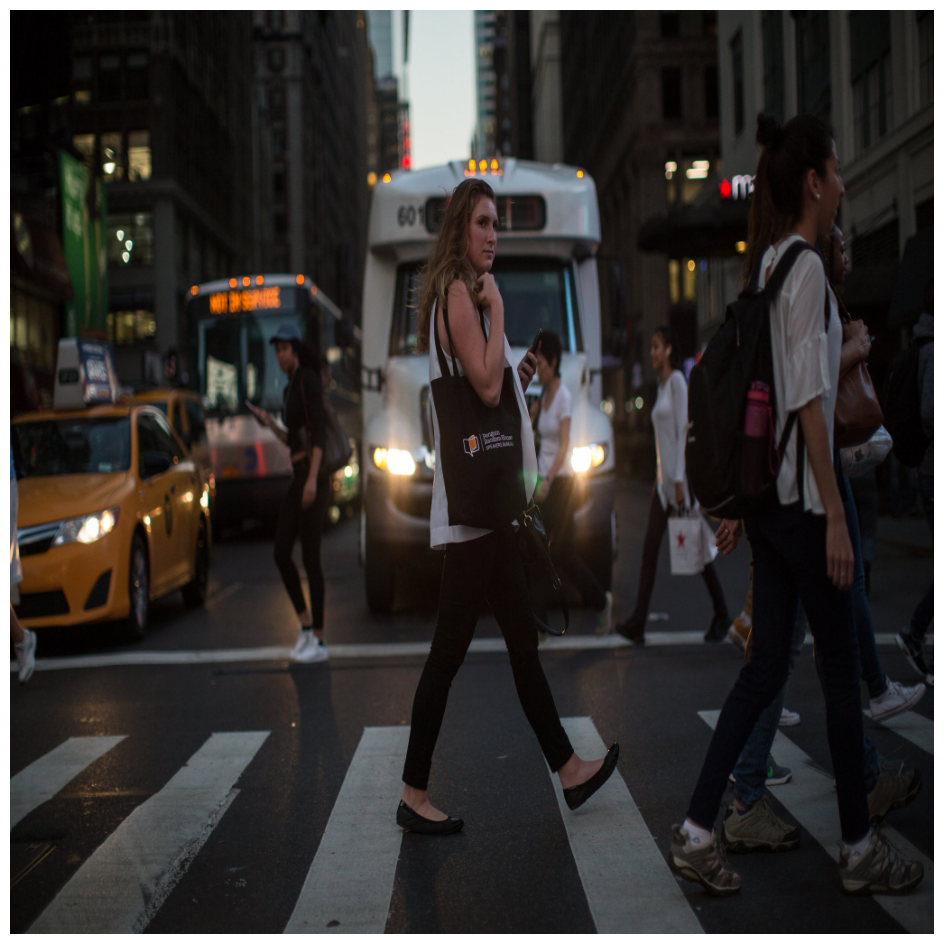

In [45]:
import supervision as sv
sv.plot_image(image_bgr)


In [46]:
mask_generator = SamAutomaticMaskGenerator(sam)
result = mask_generator.generate(image_rgb)
print(result[0].keys())
print(len(result))

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
213


In [47]:
bboxes = []
points = []
segmentations = []
areas = []

#understanding the result parameters & draw all segmentations
for mask in result:
    bboxes.append(mask['bbox'])
    points.append(mask['point_coords'])
    segmentations.append(mask['segmentation'])
    areas.append(mask['area'])
    print(mask['bbox'])


[748, 257, 138, 307]
[3, 437, 219, 253]
[435, 570, 188, 294]
[0, 804, 128, 104]
[48, 363, 72, 79]
[303, 794, 138, 229]
[750, 548, 202, 372]
[930, 0, 46, 155]
[17, 799, 269, 224]
[813, 114, 99, 185]
[4, 451, 129, 66]
[600, 783, 169, 240]
[466, 332, 106, 243]
[442, 0, 73, 174]
[435, 385, 207, 479]
[750, 253, 196, 659]
[7, 643, 58, 31]
[269, 0, 135, 341]
[867, 0, 42, 124]
[710, 399, 41, 153]
[930, 0, 44, 78]
[75, 365, 44, 70]
[866, 148, 58, 112]
[390, 163, 280, 504]
[48, 363, 35, 78]
[82, 621, 30, 43]
[974, 238, 49, 111]
[576, 0, 36, 169]
[428, 187, 245, 726]
[934, 45, 42, 110]
[0, 0, 67, 110]
[913, 389, 54, 96]
[1003, 0, 20, 104]
[317, 186, 356, 728]
[0, 922, 49, 51]
[967, 363, 56, 143]
[932, 231, 52, 55]
[9, 512, 120, 62]
[54, 155, 53, 209]
[832, 0, 25, 121]
[215, 382, 37, 63]
[428, 875, 74, 38]
[920, 461, 57, 57]
[3, 450, 130, 153]
[68, 0, 335, 416]
[513, 0, 291, 509]
[613, 811, 62, 75]
[513, 0, 510, 754]
[513, 0, 510, 505]
[138, 332, 23, 33]
[450, 186, 88, 193]
[728, 903, 82, 78]
[108

In [48]:
# sortin all the segmentation and their bbox and coordinates
segmentations = [segment['segmentation'] for segment in sorted(result, key=lambda x: x['area'], reverse=True)]
bboxes = [bbox['bbox'] for bbox in sorted(result, key=lambda x: x['area'], reverse=True)]
points = [point['point_coords'] for point in sorted(result, key=lambda x: x['area'], reverse=True)]

print(bboxes)
print(points)

print(len(segmentations))

[[513, 0, 510, 505], [513, 0, 510, 754], [68, 0, 335, 416], [513, 0, 291, 509], [253, 165, 417, 503], [390, 163, 280, 504], [65, 0, 205, 416], [317, 186, 356, 728], [428, 187, 245, 726], [785, 0, 238, 405], [4, 436, 217, 587], [3, 437, 219, 253], [416, 717, 230, 306], [269, 0, 135, 341], [0, 0, 107, 448], [303, 784, 466, 239], [303, 784, 720, 239], [750, 548, 202, 372], [750, 253, 196, 659], [0, 0, 69, 447], [17, 799, 269, 224], [748, 257, 138, 307], [435, 385, 207, 479], [435, 570, 188, 294], [303, 794, 138, 229], [600, 783, 169, 240], [264, 349, 90, 375], [512, 0, 100, 168], [466, 332, 106, 243], [830, 249, 91, 309], [442, 0, 73, 174], [672, 350, 125, 352], [969, 297, 54, 452], [577, 356, 89, 337], [512, 0, 67, 165], [421, 208, 208, 174], [421, 274, 208, 108], [611, 0, 130, 170], [813, 114, 99, 185], [610, 0, 82, 166], [220, 385, 91, 195], [218, 447, 93, 130], [54, 155, 53, 209], [3, 450, 130, 153], [4, 451, 129, 66], [534, 274, 94, 103], [0, 0, 67, 110], [695, 191, 123, 83], [450, 1

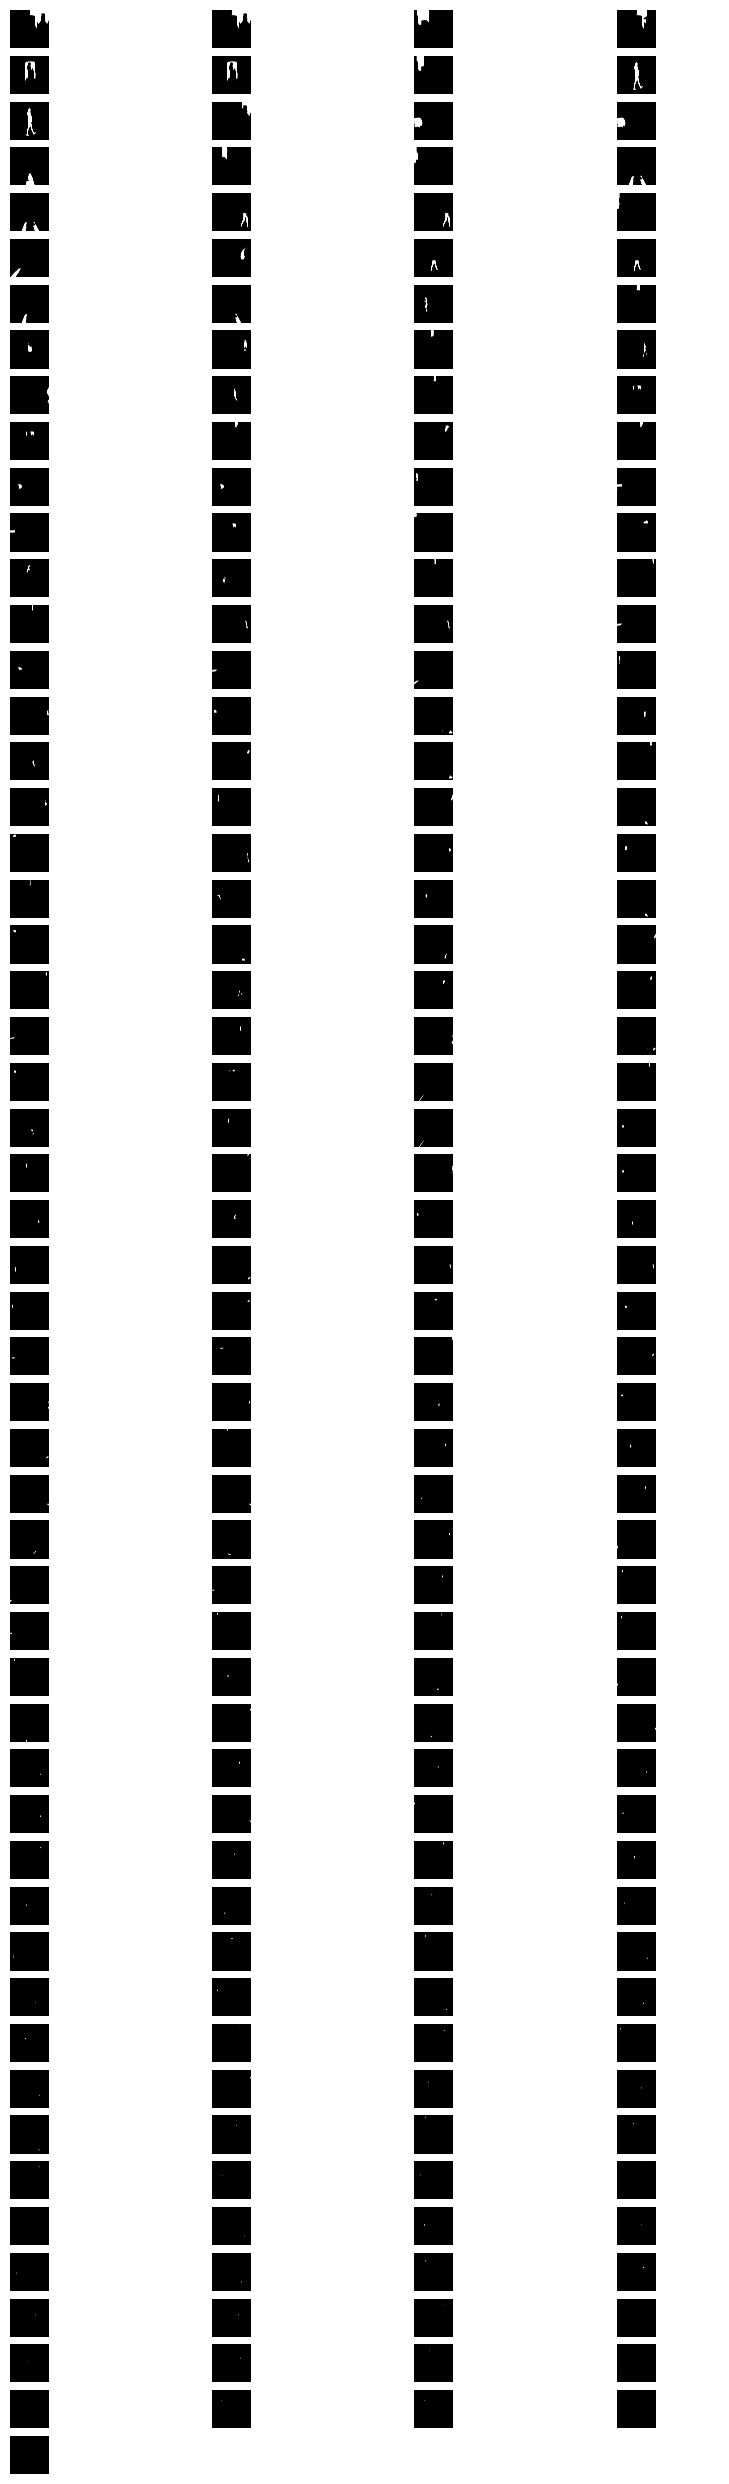

In [69]:
# Draw all msk in a grid
import supervision as sv
sv.plot_images_grid(
    images=segmentations,
    grid_size=(int(len(segmentations)/4+1),4),
    size=(10,32)
)

use indices of segmentations to check different segment of images

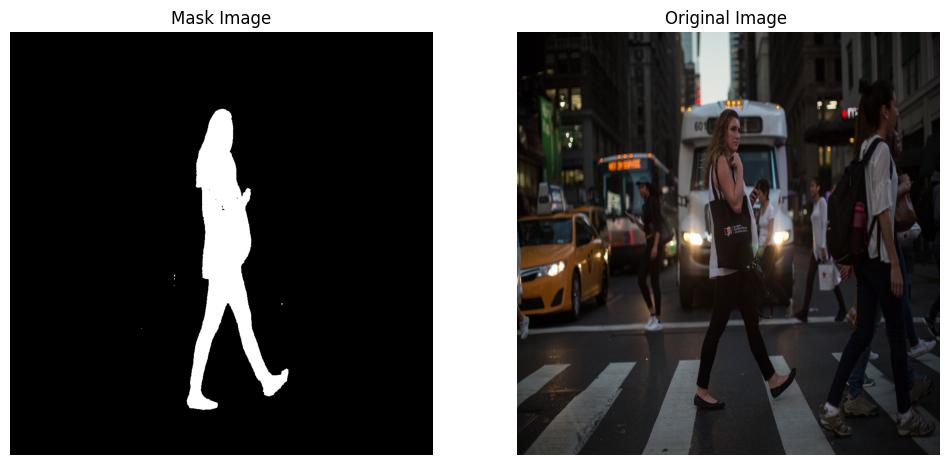

In [70]:
#Draw large or small mask and compare with original image
sv.plot_images_grid(
    images=[segmentations[7],image_bgr],
    grid_size=(1,2),
    titles=['Mask Image', 'Original Image ']
)

<h1>2 Object execution and Storage<h1/>


I am saving 10 ten images with large segments in segmented_objects folder

In [85]:
import numpy as np
from PIL import Image

def save_top_segmented_objects(image_bgr, result, output_dir, top_n=10):
    os.makedirs(output_dir, exist_ok=True)

    # Sort results by area and select the top_n largest segmentations
    top_results = sorted(result, key=lambda x: x['area'], reverse=True)[:top_n]

    for i, mask in enumerate(top_results):
        # Convert segmentation mask to binary image
        mask_image = np.array(mask['segmentation']).astype(np.uint8) * 255
        mask_image = Image.fromarray(mask_image)

        # Extract object using the mask
        object_image = Image.fromarray(image_bgr)
        object_image.putalpha(mask_image)

        # Save the extracted object
        object_image.save(os.path.join(output_dir, f'object_{i}.png'))

# Call the function
save_top_segmented_objects(image_bgr, result, '/content/project_root/data/segmented_objects')


IndexError: too many indices for tensor of dimension 2

<h2>Object Detection<h2/>

<h3><h3/>

In [33]:
!pip install tensorflow
!pip install ultralytics  # YOLOv8 is part of the Ultralytics package
!pip install opencv-python-headless
!pip install pillow
!pip install tesseract
!pip install easyocr
!pip install matplotlib
!pip install pandas
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.1/869.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562552 sha256=9b94745de440916d0cae94f60d4f425d176cbd683e3fa5a57d1afb86a9656d03
  Stored in directory: /root/.cache/pip/wheels/71/c9/aa/698c579693e83fdda9ad6d6f0d8f61ed986e27925ef576f109
Successfully built tesseract
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [53]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import json

# Load a pre-trained YOLOv8 model
segmentation_model = YOLO('yolov8n-seg.pt')  # for image segmentation
detection_model = YOLO('yolov8n.pt')         # for object detection

In [86]:
img ="/content/27DUSK1-superJumbo.jpg"

segmentation_results = det_model.predict(img,save=True,save_txt=True)
detection_results = inst_model.predict(img,save=True,save_txt=True)


# Directory to save the results and metadata
results_dir = "detection_results/"
os.makedirs(results_dir, exist_ok=True)

# Input image
img = "/content/27DUSK1-superJumbo.jpg"

# Perform object detection
detection_results = detection_model.predict(img, save=True, save_txt=True)

# Extract the result array for visualization
detection_result_array = detection_results[0].plot()


image 1/1 /content/27DUSK1-superJumbo.jpg: 448x640 9 persons, 3 cars, 2 buss, 1 truck, 1 backpack, 1 handbag, 15.2ms
Speed: 3.9ms preprocess, 15.2ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
2 labels saved to runs/detect/predict/labels

image 1/1 /content/27DUSK1-superJumbo.jpg: 448x640 11 persons, 4 cars, 2 buss, 1 truck, 1 backpack, 14.7ms
Speed: 3.6ms preprocess, 14.7ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict
2 labels saved to runs/segment/predict/labels

image 1/1 /content/27DUSK1-superJumbo.jpg: 448x640 9 persons, 3 cars, 2 buss, 1 truck, 1 backpack, 1 handbag, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict4
1 label saved to runs/detect/predict4/labels


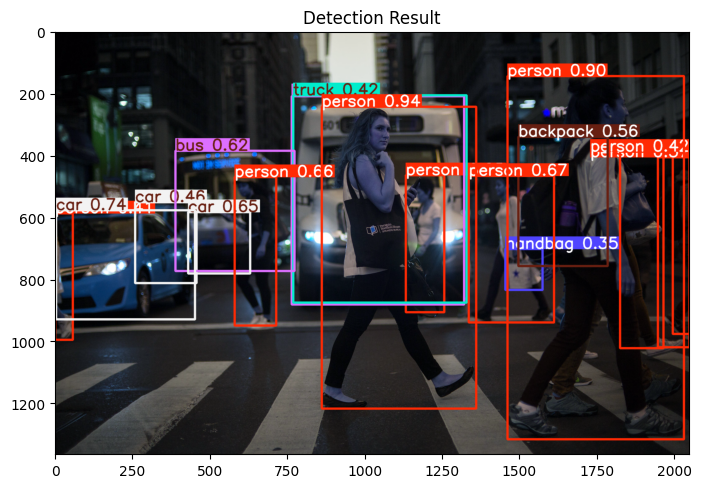

Detected a person with a confidence of 0.94.
Detected a person with a confidence of 0.90.
Detected a car with a confidence of 0.74.
Detected a person with a confidence of 0.67.
Detected a person with a confidence of 0.66.
Detected a car with a confidence of 0.65.
Detected a bus with a confidence of 0.62.
Detected a backpack with a confidence of 0.56.
Detected a car with a confidence of 0.46.
Detected a truck with a confidence of 0.42.
Detected a person with a confidence of 0.42.
Detected a person with a confidence of 0.41.
Detected a person with a confidence of 0.37.
Detected a bus with a confidence of 0.35.
Detected a handbag with a confidence of 0.35.
Detected a person with a confidence of 0.28.
Detected a person with a confidence of 0.25.
Object identification completed and metadata stored in project_root/data/detection_results/detection_metadata.json.


In [108]:
# Display detection result
fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('Detection Result')
ax1.imshow(detection_results[0].plot())
plt.show()

# Directory to store results
import os
results_dir = 'project_root/data/detection_results/'
os.makedirs(results_dir, exist_ok=True)

# Extract object classes and confidence scores
object_info_list = []
for result in detection_results:
    for box in result.boxes:
        class_id = int(box.cls)  # Class ID of detected object
        confidence = float(box.conf)  # Confidence score
        class_name = det_model.names[class_id]  # Get class name

        # Bounding box coordinates
        bbox = box.xyxy.cpu().numpy()[0]  # Bounding box coordinates

        # Create a human-readable description
        description = f"Detected a {class_name} with a confidence of {confidence:.2f}."
        print(description)

        # Append information to the list
        object_info_list.append({
            "class_id": class_id,
            "class_name": class_name,
            "confidence": confidence,
            "bbox": bbox.tolist(),
            "description": description
        })

# Save the object information as JSON metadata
metadata_path = os.path.join(results_dir, "detection_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(object_info_list, f, indent=4)

print(f"Object identification completed and metadata stored in {metadata_path}.")

<h1>4. Text/Data Extraction from Objects<h1/>

In [ ]:
!pip install easyocr


In [111]:
import os
import json
import cv2
import easyocr
from PIL import Image
import numpy as np

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Define directories
segmented_objects_dir = 'project_root/data/segmented_objects/'  # Directory where segmented object images are stored
text_extraction_dir = 'project_root/data/text_extraction/'       # Directory to save text extraction results
os.makedirs(text_extraction_dir, exist_ok=True)

# Load metadata
metadata_path = 'project_root/data/detection_results/detection_metadata.json'
with open(metadata_path, 'r') as f:
    object_info_list = json.load(f)

# Extract text/data from each segmented object image
extracted_text_data = []

for obj_info in object_info_list:
    obj_id = obj_info['class_id']
    img_path = os.path.join(segmented_objects_dir, f"object_{obj_id}.jpg")  # Adjust the filename format if necessary
    if os.path.exists(img_path):
        # Load image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Perform OCR
        results = reader.readtext(img_rgb)

        # Extract text and data
        text_data = " ".join([result[1] for result in results])

        # Save extracted text data
        extracted_text_data.append({
            "object_id": obj_id,
            "text": text_data
        })

        # Save text to a file
        with open(os.path.join(text_extraction_dir, f"object_{obj_id}_text.txt"), 'w') as text_file:
            text_file.write(text_data)

# Save the extracted text data as JSON
extracted_text_metadata_path = os.path.join(text_extraction_dir, "extracted_text_metadata.json")
with open(extracted_text_metadata_path, 'w') as f:
    json.dump(extracted_text_data, f, indent=4)

print(f"Text extraction completed and metadata stored in {extracted_text_metadata_path}.")


Text extraction completed and metadata stored in project_root/data/text_extraction/extracted_text_metadata.json.


<h1><h1/>

<h1>Generating Summary<h1/>


In [91]:
!pip install transformers


In [114]:
from transformers import pipeline
import json
import os

# Initialize summarization model
summarizer = pipeline("summarization")

# Define directories
text_extraction_dir = 'project_root/data/text_extraction/'  # Directory where text extraction results are saved
summarization_dir = 'project_root/data/summarization/'       # Directory to save summaries
os.makedirs(summarization_dir, exist_ok=True)

# Load extracted text data
extracted_text_metadata_path = os.path.join(text_extraction_dir, "extracted_text_metadata.json")
with open(extracted_text_metadata_path, 'r') as f:
    extracted_text_data = json.load(f)

# Generate summaries
summaries = []
for obj_data in extracted_text_data:
    obj_id = obj_data['object_id']
    text = obj_data['text']

    if text.strip():  # Check if text is not empty
        summary = summarizer(text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
    else:
        summary = "No text extracted."

    summaries.append({
        "object_id": obj_id,
        "summary": summary
    })

# Save the summaries as JSON
summarization_metadata_path = os.path.join(summarization_dir, "summarized_object_attributes.json")
with open(summarization_metadata_path, 'w') as f:
    json.dump(summaries, f, indent=4)

print(f"Object summaries generated and stored in {summarization_metadata_path}.")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Object summaries generated and stored in project_root/data/summarization/summarized_object_attributes.json.


<h1>Data Mapping <h1/> <br>
**Task**: Map all extracted data and attributes to each object and the master input image.<br>
**Deliverables**: Code to map unique IDs, descriptions, extracted text/data, and summaries to each object, and a data structure (e.g., JSON) representing the mapping.

In [115]:
import json
import os

# Define directories
summarization_dir = 'project_root/data/summarization/'       # Directory where summaries are saved
text_extraction_dir = 'project_root/data/text_extraction/'   # Directory where text extraction results are saved
detection_results_dir = 'project_root/data/detection_results/'  # Directory where detection metadata is saved
data_mapping_dir = 'project_root/data/data_mapping/'          # Directory to save the data mapping
os.makedirs(data_mapping_dir, exist_ok=True)

# Load metadata and summaries
with open(os.path.join(detection_results_dir, "detection_metadata.json"), 'r') as f:
    detection_metadata = json.load(f)

with open(os.path.join(text_extraction_dir, "extracted_text_metadata.json"), 'r') as f:
    extracted_text_data = json.load(f)

with open(os.path.join(summarization_dir, "summarized_object_attributes.json"), 'r') as f:
    summaries = json.load(f)

# Create a dictionary to hold the mapped data
data_mapping = {}

for obj in detection_metadata:
    obj_id = obj['class_id']
    # Initialize object data entry
    data_mapping[obj_id] = {
        "class_name": obj['class_name'],
        "confidence": obj['confidence'],
        "bbox": obj['bbox'],
        "description": obj['description'],
        "text": next((item['text'] for item in extracted_text_data if item['object_id'] == obj_id), "No text extracted."),
        "summary": next((item['summary'] for item in summaries if item['object_id'] == obj_id), "No summary available.")
    }

# Save the data mapping as JSON
data_mapping_path = os.path.join(data_mapping_dir, "data_mapping.json")
with open(data_mapping_path, 'w') as f:
    json.dump(data_mapping, f, indent=4)

print(f"Data mapping completed and stored in {data_mapping_path}.")


Data mapping completed and stored in project_root/data/data_mapping/data_mapping.json.


<h1>Step 7: Output Generation
<h1/>

Annotate the Image:

In [120]:
original_img_path = 'project_root/data/input_images/27DUSK1-superJumbo.jpg'  # Ensure this path is correct


In [121]:
original_image = cv2.imread(original_img_path)
if original_image is None:
    raise FileNotFoundError(f"Image not found at {original_img_path}")
print(original_image.shape)


(1365, 2048, 3)


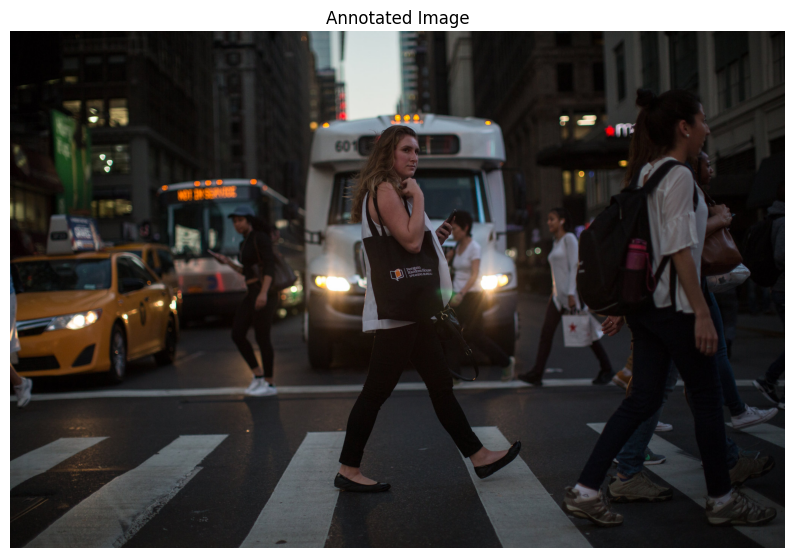

In [124]:
import matplotlib.pyplot as plt

# Display the image before saving
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Annotated Image')
plt.axis('off')
plt.show()


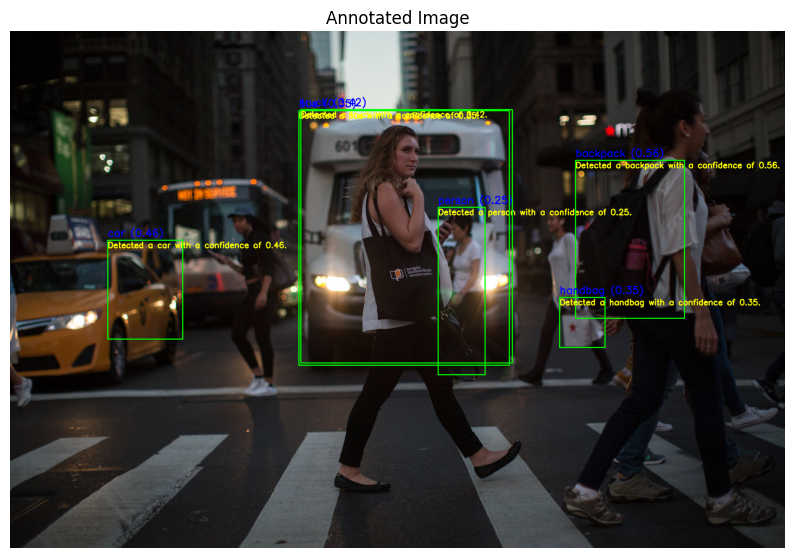

Annotated image saved at project_root/data/output/annotated_image.jpg
Summary table saved at project_root/data/output/summary_table.csv


In [127]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import json

# Define directories
data_mapping_dir = 'project_root/data/data_mapping/'
output_dir = 'project_root/data/output/'
os.makedirs(output_dir, exist_ok=True)

# Load the data mapping
with open(os.path.join(data_mapping_dir, "data_mapping.json"), 'r') as f:
    data_mapping = json.load(f)

# Load the original image
original_img_path = 'project_root/data/input_images/27DUSK1-superJumbo.jpg'
original_image = cv2.imread(original_img_path)
if original_image is None:
    raise FileNotFoundError(f"Image not found at {original_img_path}")

# Draw annotations on the image
for obj_id, obj_data in data_mapping.items():
    bbox = obj_data['bbox']
    class_name = obj_data['class_name']
    confidence = obj_data['confidence']
    description = obj_data['description']

    # Draw bounding box
    cv2.rectangle(original_image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

    # Put text label
    label = f"{class_name} ({confidence:.2f})"
    cv2.putText(original_image, label, (int(bbox[0]), int(bbox[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Add description text
    cv2.putText(original_image, description, (int(bbox[0]), int(bbox[1] + 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

# Display the image before saving
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Annotated Image')
plt.axis('off')
plt.show()

# Save annotated image
annotated_image_path = os.path.join(output_dir, "annotated_image.jpg")
cv2.imwrite(annotated_image_path, original_image)
print(f"Annotated image saved at {annotated_image_path}")

# Create summary table
summary_data = []
for obj_id, obj_data in data_mapping.items():
    summary_data.append({
        "Object ID": obj_id,
        "Class Name": obj_data['class_name'],
        "Confidence": obj_data['confidence'],
        "Bounding Box": obj_data['bbox'],
        "Description": obj_data['description'],
        "Extracted Text": obj_data['text'],
        "Summary": obj_data['summary']
    })

# Save summary table as CSV
summary_table_path = os.path.join(output_dir, "summary_table.csv")
df = pd.DataFrame(summary_data)
df.to_csv(summary_table_path, index=False)

print(f"Summary table saved at {summary_table_path}")
